In [ ]:
# This is a DIY analog of the Bear classification model seen in week 2.  
# Here is my model for differentiating between 2 models (heehee): Kaia Gerber & Cindy Crawford

In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import os
key = "HARD CODE THIS!"
# do NOT push this into my github!  sub in last minute when i actually run this in jupyter!

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

got 150 images


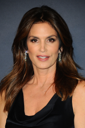

In [24]:
testImgGrab = search_images_bing(key, 'Cindy Crawford')
ims = testImgGrab.attrgot('contentUrl')
print(f"got {len(ims)} images")
dest = 'images/testCrawford.jpg'
download_url(ims[1], dest)
im = Image.open(dest)
im.to_thumb(128,128)

In [42]:
names = {'Cindy': 'Cindy Crawford', 'Kaia': 'Kaia Gerber'}
path = Path('CindyKaia')

if not path.exists():
    path.mkdir()
    for firstName, fullName in names.items():
        dest = (path/firstName)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, fullName)
        download_images(dest, urls=results.attrgot('contentUrl'))
        
        # After this, should see folder on left panel and images therein

In [43]:
fns = get_image_files(path)
fns

(#298) [Path('CindyKaia/Cindy/00000100.jpg'),Path('CindyKaia/Cindy/00000146.jpg'),Path('CindyKaia/Cindy/00000073.jpg'),Path('CindyKaia/Cindy/00000035.jpg'),Path('CindyKaia/Cindy/00000061.jpg'),Path('CindyKaia/Cindy/00000078.jpg'),Path('CindyKaia/Cindy/00000055.jpg'),Path('CindyKaia/Cindy/00000068.jpg'),Path('CindyKaia/Cindy/00000053.jpg'),Path('CindyKaia/Cindy/00000005.jpg')...]

In [44]:
failed = verify_images(fns)
print(f"Any failed images? {failed}")
failed.map(Path.unlink);

Any failed images? []


In [45]:
ladies = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,  
    splitter=RandomSplitter(valid_pct=0.2, seed=42), 
    get_y=parent_label,
    item_tfms=Resize(128))

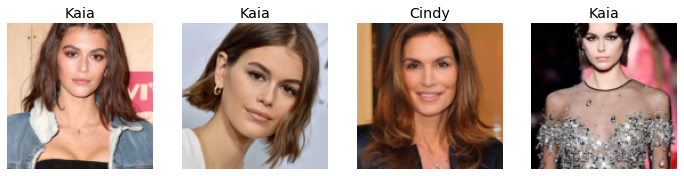

In [46]:
# show a sample as is
dls = ladies.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [47]:
#  combine both random resize crops AND funky data augmentations 
        #  will show warning bc of deprecated stuff but ignore it
# ladies = ladies.new(
#     item_tfms=RandomResizedCrop(224, min_scale=0.5),
#     batch_tfms=aug_transforms())


# mmmm... no i want to just do resizes
ladies = ladies.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = ladies.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [48]:
### STEP 3: xyz_learner & STEP 4: learn.fine_tune/fit on it
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.156853,1.249674,0.474576,00:09


epoch,train_loss,valid_loss,error_rate,time
0,1.007037,0.730065,0.305085,00:10
1,0.895111,0.618178,0.186441,00:09
2,0.764570,0.684955,0.237288,00:10
3,0.697642,0.605687,0.237288,00:09


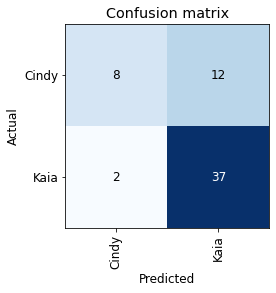

In [49]:
### ANALYZE via confusion matrix.  color coded.

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

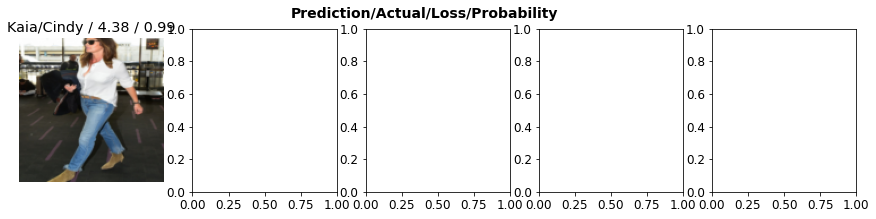

In [55]:
### ANALYZE via top losses
    # Weirdly, only 1 picture shows up both tries.  MK had same prob w/ Pitt/Buscemi model.

interp.plot_top_losses(5, nrows=1)

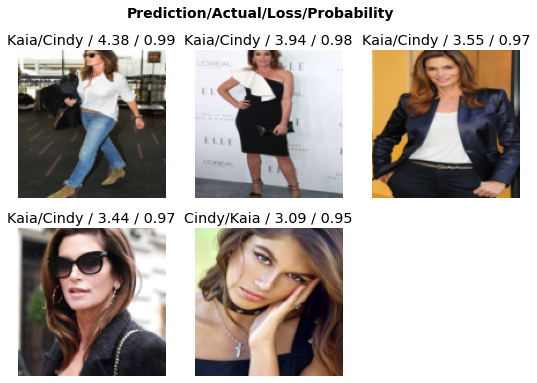

In [56]:
# FROM https://forums.fast.ai/t/plot-top-losses-problem/92015/12
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)
        
        
# Now I can see top 5!
plot_top_losses_fix(interp, 5)

In [58]:
import fastai
fastai.__version__

'2.5.3'